<a href="https://colab.research.google.com/github/sofiahTas/IDN_deforest/blob/main/Copy_of_sdgs_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & Import Library

In [98]:
# Install & Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

Fungsi Fungsi Library yang digunakan
1. pandas (pd) → digunakan untuk memanipulasi dan menganalisis data dalam bentuk tabel (DataFrame).
2. numpy (np) → digunakan untuk operasi numerik seperti perhitungan matematis, array, dan vektor.
3. matplotlib.pyplot (plt) → digunakan untuk membuat grafik dasar seperti garis, batang, atau scatter plot
4. seaborn (sns) → digunakan untuk membuat visualisasi statistik yang lebih menarik dan informatif dibanding matplotlib standar.
5. LabelEncoder → mengubah data kategorikal menjadi angka agar bisa diproses oleh model machine learning.
6. mean_squared_error (MSE) → mengukur selisih kuadrat rata-rata antara nilai prediksi dan aktual.
7. mean_absolute_error (MAE) → mengukur selisih absolut rata-rata antara nilai prediksi dan aktual.
8. train_test_split → membagi dataset menjadi data latih dan data uji untuk melatih dan menguji model.
9. xgboost (Extreme Gradient Boosting) → algoritma pembelajaran mesin yang sangat efisien dan populer untuk regresi maupun klasifikasi.
10. joblib → digunakan untuk menyimpan dan memuat model machine learning agar tidak perlu dilatih ulang.
11. r2_score (R-squared) → mengukur seberapa baik model menjelaskan variabilitas data (semakin mendekati 1, semakin baik).


In [99]:
# Tampilan dataframe yang lebih rapi
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Tree Cover Loss

In [100]:
# Load Dataset dari github
file_path = 'https://raw.githubusercontent.com/sofiahTas/IDN_deforest/main/IDN.xlsx'

# Baca sheet Subnational 1 tree cover loss
df = pd.read_excel(file_path, sheet_name="Subnational 1 tree cover loss")

print("Dataset loaded with shape:", df.shape)
df.head()

Dataset loaded with shape: (272, 31)


,country,subnational1,threshold,area_ha,extent_2000_ha,extent_2010_ha,gain_2000-2012_ha,tc_loss_ha_2001,tc_loss_ha_2002,tc_loss_ha_2003,tc_loss_ha_2004,tc_loss_ha_2005,tc_loss_ha_2006,tc_loss_ha_2007,tc_loss_ha_2008,tc_loss_ha_2009,tc_loss_ha_2010,tc_loss_ha_2011,tc_loss_ha_2012,tc_loss_ha_2013,tc_loss_ha_2014,tc_loss_ha_2015,tc_loss_ha_2016,tc_loss_ha_2017,tc_loss_ha_2018,tc_loss_ha_2019,tc_loss_ha_2020,tc_loss_ha_2021,tc_loss_ha_2022,tc_loss_ha_2023,tc_loss_ha_2024
0,Indonesia,Aceh,0,5683650,5683650,5683650,129164,18402,11039,11858,19315,26677,21392,24304,36867,69393,40897,47777,50225,44602,63050,35718,54064,49775,50240,31054,33716,34795,32777,43810,52495
1,Indonesia,Aceh,10,5683650,5090906,4996298,129164,18325,10988,11830,19213,26563,21326,24221,36785,69241,40821,47582,49582,41930,59577,34386,50990,46781,47054,29148,31009,32516,30495,40110,47497
2,Indonesia,Aceh,15,5683650,5050168,4946855,129164,18309,10974,11827,19187,26537,21311,24202,36770,69196,40802,47550,49526,41776,59276,34261,50711,46489,46775,28962,30750,32292,30263,39754,47042
3,Indonesia,Aceh,20,5683650,5029128,4932162,129164,18297,10966,11822,19168,26510,21299,24188,36753,69166,40787,47527,49478,41639,59025,34159,50498,46263,46546,28829,30574,32117,30095,39486,46720
4,Indonesia,Aceh,25,5683650,5014670,4908701,129164,18289,10961,11818,19156,26495,21295,24181,36746,69148,40779,47513,49451,41567,58898,34109,50373,46141,46416,28758,30474,32020,30014,39341,46528


Menyaring dataset agar hanya mencakup data dengan threshold sebesar 30% (standar Global Forest Watch untuk tree cover loss).

In [101]:
# Filter threshold 30% (standar Global Forest Watch)
df = df[df["threshold"] == 30].reset_index(drop=True)
print("Filtered rows (threshold=30%):", len(df))

Filtered rows (threshold=30%): 34


In [102]:
# Ubah format wide → long (yearly time series)
# Kolom yang memuat data loss per tahun (2001–2024)
loss_cols = [col for col in df.columns if "tc_loss_ha_" in col]

# Ubah menjadi long format
df_long = df.melt(
    id_vars=["country", "subnational1", "threshold", "extent_2000_ha"],
    value_vars=loss_cols,
    var_name="year",
    value_name="loss_ha"
)

# Ambil angka tahun dari nama kolom
df_long["year"] = df_long["year"].str.extract(r"(\d{4})").astype(int)

# Urutkan
df_long = df_long.sort_values(["subnational1", "year"]).reset_index(drop=True)

print("Long-format dataset ready:", df_long.shape)
df_long.head()

Long-format dataset ready: (816, 6)


,country,subnational1,threshold,extent_2000_ha,year,loss_ha
0,Indonesia,Aceh,30,4984708,2001,18278
1,Indonesia,Aceh,30,4984708,2002,10952
2,Indonesia,Aceh,30,4984708,2003,11816
3,Indonesia,Aceh,30,4984708,2004,19138
4,Indonesia,Aceh,30,4984708,2005,26479


In [103]:
# Hitung Laju Deforestasi Tahunan (% dari luas awal)
# Gunakan extent_2000_ha sebagai baseline luas hutan
df_long["loss_rate_%"] = (df_long["loss_ha"] / df_long["extent_2000_ha"]) * 100

# Cek total per tahun (nasional)
national_trend = (
    df_long.groupby("year")["loss_ha"].sum().reset_index()
)
national_trend["loss_rate_%"] = national_trend["loss_ha"] / df_long["extent_2000_ha"].sum() * 100

national_trend.head()

,year,loss_ha,loss_rate_%
0,2001,744082,0.02
1,2002,855266,0.02
2,2003,544809,0.01
3,2004,1289035,0.03
4,2005,1182433,0.03


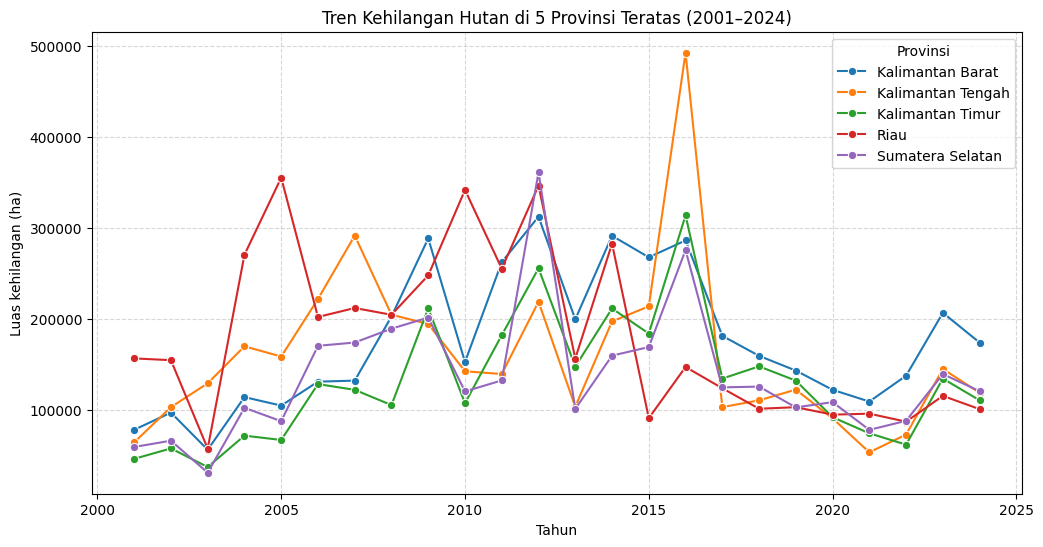

In [104]:
# Visualisasi Contoh Per Provinsi
# Pilih 5 provinsi dengan rata-rata loss terbesar
top5 = (
    df_long.groupby("subnational1")["loss_ha"].mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_long[df_long["subnational1"].isin(top5)],
    x="year",
    y="loss_ha",
    hue="subnational1",
    marker="o"
)
plt.title("Tren Kehilangan Hutan di 5 Provinsi Teratas (2001–2024)")
plt.ylabel("Luas kehilangan (ha)")
plt.xlabel("Tahun")
plt.legend(title="Provinsi")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Gambar di atas merupakan grafik tren kehilangan hutan (deforestasi) di 5 provinsi teratas di Indonesia selama periode 2001–2024. Grafik ini menggambarkan perubahan luas hutan yang hilang setiap tahun (dalam hektare) di tiap provinsi.

In [105]:
output_path = "/content/deforestation_ready.csv"
df_long.to_csv(output_path, index=False)
print("File siap modelling disimpan di:", output_path)

File siap modelling disimpan di: /content/deforestation_ready.csv


menyimpan file hasil plotting


# Carbon Data


In [106]:
# Baca sheet Subnational 1 tree cover loss
df_carbon = pd.read_excel(file_path, sheet_name="Subnational 1 carbon data")

print("Dataset loaded with shape:", df.shape)
df_carbon = df_carbon[df_carbon["umd_tree_cover_density_2000__threshold"] == 30]
df_carbon.head()

Dataset loaded with shape: (34, 31)


,country,subnational1,umd_tree_cover_density_2000__threshold,umd_tree_cover_extent_2000__ha,gfw_aboveground_carbon_stocks_2000__Mg_C,avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1,gfw_forest_carbon_gross_emissions__Mg_CO2e_yr-1,gfw_forest_carbon_gross_removals__Mg_CO2_yr-1,gfw_forest_carbon_net_flux__Mg_CO2e_yr-1,gfw_forest_carbon_gross_emissions_2001__Mg_CO2e,gfw_forest_carbon_gross_emissions_2002__Mg_CO2e,gfw_forest_carbon_gross_emissions_2003__Mg_CO2e,gfw_forest_carbon_gross_emissions_2004__Mg_CO2e,gfw_forest_carbon_gross_emissions_2005__Mg_CO2e,gfw_forest_carbon_gross_emissions_2006__Mg_CO2e,gfw_forest_carbon_gross_emissions_2007__Mg_CO2e,gfw_forest_carbon_gross_emissions_2008__Mg_CO2e,gfw_forest_carbon_gross_emissions_2009__Mg_CO2e,gfw_forest_carbon_gross_emissions_2010__Mg_CO2e,gfw_forest_carbon_gross_emissions_2011__Mg_CO2e,gfw_forest_carbon_gross_emissions_2012__Mg_CO2e,gfw_forest_carbon_gross_emissions_2013__Mg_CO2e,gfw_forest_carbon_gross_emissions_2014__Mg_CO2e,gfw_forest_carbon_gross_emissions_2015__Mg_CO2e,gfw_forest_carbon_gross_emissions_2016__Mg_CO2e,gfw_forest_carbon_gross_emissions_2017__Mg_CO2e,gfw_forest_carbon_gross_emissions_2018__Mg_CO2e,gfw_forest_carbon_gross_emissions_2019__Mg_CO2e,gfw_forest_carbon_gross_emissions_2020__Mg_CO2e,gfw_forest_carbon_gross_emissions_2021__Mg_CO2e,gfw_forest_carbon_gross_emissions_2022__Mg_CO2e,gfw_forest_carbon_gross_emissions_2023__Mg_CO2e,gfw_forest_carbon_gross_emissions_2024__Mg_CO2e
5,Indonesia,Aceh,30,4984708,653101544,544,22138237,13571223,8567015,10781164,6627106,8026562,11548791,17345183,13845766,15217238,24828757,44802236,25634918,31277948,31813634,24213932,36641364,20419815,29597570,26984846,27851704,17771125,18601460,18974147,16989501,23348363,28174569
13,Indonesia,Bali,30,365485,39151857,491,215607,2388648,-2173040,260325,190618,117400,219024,148261,321987,315182,146969,232894,125464,133383,452548,204263,508923,76643,96433,155514,161045,429538,109182,124862,168103,365681,110329
21,Indonesia,Bangka Belitung,30,1332845,106312312,283,15221676,7397481,7824198,7005063,5562797,3487235,11477498,10079529,10751927,12008264,11226378,33402713,12361376,16964282,21360184,9630177,22150159,22577478,36821355,12950327,10287578,10721349,12029032,15885973,16706101,24505926,15367547
29,Indonesia,Banten,30,561723,56287349,513,1321451,3632176,-2310725,618476,1042788,164982,827685,311460,1089522,605411,562003,1701980,983311,1374312,2150205,1100213,1390639,1638703,1155343,2099270,2117123,2857726,1271610,1181129,929614,2388259,2153062
37,Indonesia,Bengkulu,30,1795200,231746921,499,13933685,7408354,6525332,10135589,7523117,5800440,18343674,9223426,15951261,12489087,15627311,13382843,11253547,18100728,20702595,9464223,13959398,14343184,16964333,18982493,17413860,12357843,11420715,9891659,16676254,19303155,15097704


In [107]:
# Memilih Kolom Carbon (stok karbon & emisi tahunan)
carbon_cols = [
    "country", "subnational1", "umd_tree_cover_density_2000__threshold",
    "gfw_aboveground_carbon_stocks_2000__Mg_C",
    "avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1"
]

In [108]:
# Kolom emisi tahunan (filter only columns ending with a year)
emission_cols = [c for c in df_carbon.columns if "gross_emissions_" in c]
carbon_long = df_carbon.melt(
    id_vars=carbon_cols,
    value_vars=emission_cols,
    var_name="year",
    value_name="emission_Mg_CO2e"
)

In [109]:
# Ambil angka tahun dari nama kolom
carbon_long["year"] = carbon_long["year"].str.extract(r"(\d{4})")

# Hapus baris tanpa angka tahun (NaN)
carbon_long = carbon_long.dropna(subset=["year"]).reset_index(drop=True)

# Konversi ke integer
carbon_long["year"] = carbon_long["year"].astype(int)
carbon_long["year"].unique()[:10]

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])

# Merge dengan tree cover loss

In [110]:
# Gabungkan dengan tree cover loss
merged = pd.merge(
    df_long,
    carbon_long,
    left_on=["subnational1", "year"],
    right_on=["subnational1", "year"],
    how="left"
)

print("Dataset gabungan deforestasi + karbon:", merged.shape)
merged.head()

Dataset gabungan deforestasi + karbon: (816, 12)


,country_x,subnational1,threshold,extent_2000_ha,year,loss_ha,loss_rate_%,country_y,umd_tree_cover_density_2000__threshold,gfw_aboveground_carbon_stocks_2000__Mg_C,avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1,emission_Mg_CO2e
0,Indonesia,Aceh,30,4984708,2001,18278,0.37,Indonesia,30,653101544,544,10781164
1,Indonesia,Aceh,30,4984708,2002,10952,0.22,Indonesia,30,653101544,544,6627106
2,Indonesia,Aceh,30,4984708,2003,11816,0.24,Indonesia,30,653101544,544,8026562
3,Indonesia,Aceh,30,4984708,2004,19138,0.38,Indonesia,30,653101544,544,11548791
4,Indonesia,Aceh,30,4984708,2005,26479,0.53,Indonesia,30,653101544,544,17345183


# Visualisasi Tren

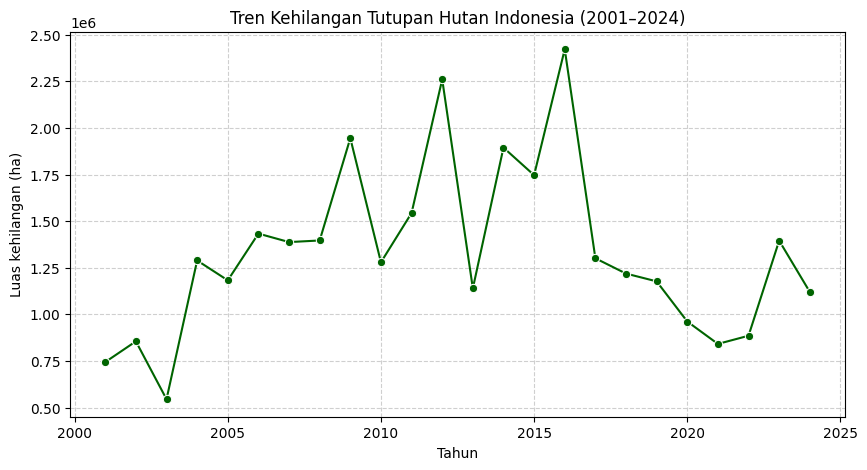

In [111]:
# Visualisasi Tren Tree Cover Loss Nasional
plt.figure(figsize=(10, 5))
sns.lineplot(data=national_trend, x="year", y="loss_ha", marker="o", color="darkgreen")
plt.title("Tren Kehilangan Tutupan Hutan Indonesia (2001–2024)")
plt.ylabel("Luas kehilangan (ha)")
plt.xlabel("Tahun")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Gambar di atas merupakan visualisasi tren kehilangan tutupan hutan (Tree Cover Loss) secara nasional di Indonesia dalam periode 2001–2024.
Grafik ini menunjukkan bahwa:

1. Kehilangan tutupan hutan Indonesia mencapai puncaknya sekitar 2015–2016.

2. Setelah itu, tren deforestasi nasional menurun tajam hingga tahun 2024.

3. Upaya konservasi, pengawasan lahan, dan kebijakan lingkungan kemungkinan besar berkontribusi pada penurunan tersebut.

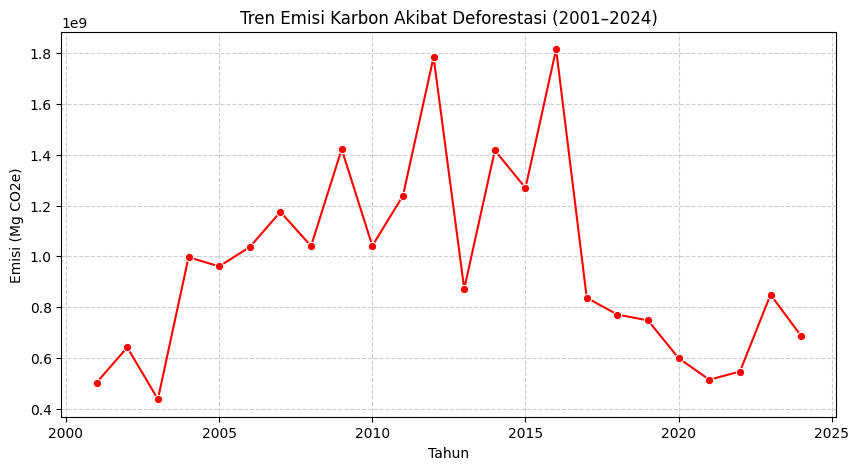

In [112]:
# Total emisi karbon per tahun di Indonesia
carbon_trend = merged.groupby("year")["emission_Mg_CO2e"].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=carbon_trend, x="year", y="emission_Mg_CO2e", color="red", marker="o")
plt.title("Tren Emisi Karbon Akibat Deforestasi (2001–2024)")
plt.xlabel("Tahun")
plt.ylabel("Emisi (Mg CO2e)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Gambar di atas menunjukkan visualisasi tren emisi karbon akibat deforestasi di Indonesia selama periode 2001–2024. Grafik ini menampilkan bagaimana jumlah emisi karbon (dalam satuan Mg CO₂e) berubah dari tahun ke tahun akibat kehilangan tutupan hutan.
Grafik menunjukkan bahwa :

1. Emisi karbon akibat deforestasi mencapai puncak antara 2010–2016, dengan nilai lebih dari 1,5 miliar ton CO₂e per tahun.
2. Setelah 2016, tren menurun signifikan, menandakan dampak positif dari kebijakan pengendalian deforestasi nasional.
3. Meski tren menurun, emisi masih ada, sehingga upaya reduksi deforestasi dan restorasi hutan perlu terus ditingkatkan.

# Data Cleaning (After Merged)

Data Cleaning merupakan proses membersihkan dan menyiapkan data mentah agar siap digunakan untuk analisis atau pemodelan.
Tujuannya adalah untuk memastikan data bebas dari kesalahan, duplikasi, nilai kosong, atau kolom yang tidak relevan sehingga hasil analisis menjadi akurat dan dapat dipercaya.

In [113]:
cols_keep = [
    "subnational1", "year",
    "extent_2000_ha", "loss_ha", "loss_rate_%",
    "gfw_aboveground_carbon_stocks_2000__Mg_C",
    "avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1",
    "emission_Mg_CO2e"
]

df_clean = merged[cols_keep].copy()

Estimasi Emisi Karbon Berdasarkan Deforestasi

In [114]:
# Menambahkan Kolom Estimasi Karbon Hilang (C → CO₂e)
df_clean["emission_estimated_CO2e"] = (
    df_clean["loss_ha"] *
    df_clean["avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1"] *
    3.67 # konversi C ke CO₂e
)

In [115]:
# Cek jumlah duplikat berdasarkan provinsi dan tahun
df_clean.duplicated(subset=["subnational1", "year"]).sum()

np.int64(0)

In [116]:
df_clean.head()

,subnational1,year,extent_2000_ha,loss_ha,loss_rate_%,gfw_aboveground_carbon_stocks_2000__Mg_C,avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1,emission_Mg_CO2e,emission_estimated_CO2e
0,Aceh,2001,4984708,18278,0.37,653101544,544,10781164,"36,491,661.44"
1,Aceh,2002,4984708,10952,0.22,653101544,544,6627106,"21,865,448.96"
2,Aceh,2003,4984708,11816,0.24,653101544,544,8026562,"23,590,407.68"
3,Aceh,2004,4984708,19138,0.38,653101544,544,11548791,"38,208,634.24"
4,Aceh,2005,4984708,26479,0.53,653101544,544,17345183,"52,864,793.92"


In [117]:
df_clean["carbon_loss_MgC"] = df_clean["loss_ha"] * df_clean["avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1"] # menghitung carbon loss

df_clean[["subnational1", "year", "loss_ha", "carbon_loss_MgC", "emission_estimated_CO2e"]].head()

,subnational1,year,loss_ha,carbon_loss_MgC,emission_estimated_CO2e
0,Aceh,2001,18278,9943232,"36,491,661.44"
1,Aceh,2002,10952,5957888,"21,865,448.96"
2,Aceh,2003,11816,6427904,"23,590,407.68"
3,Aceh,2004,19138,10411072,"38,208,634.24"
4,Aceh,2005,26479,14404576,"52,864,793.92"


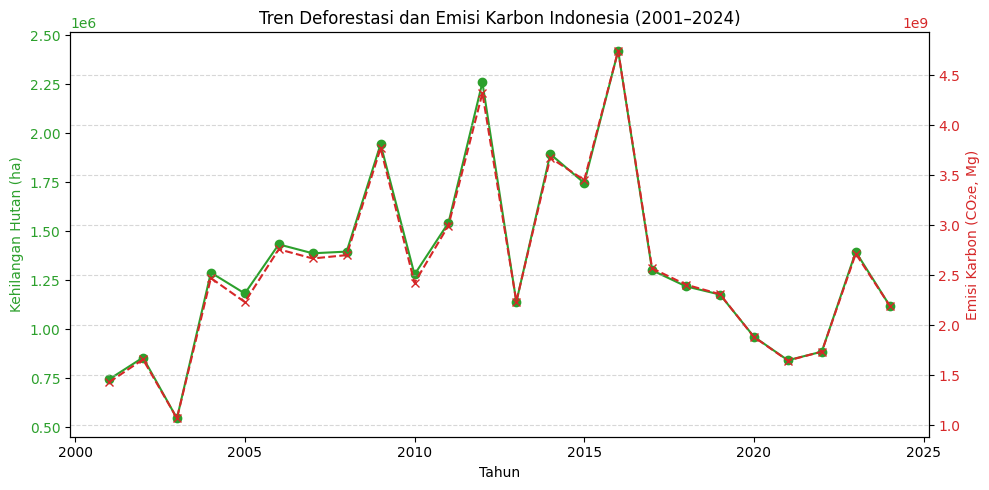

In [118]:
# Visualisasi Tren Emisi Carbon dengan Tree Cover Loss Nasional
national = (
    df_clean.groupby("year")[["loss_ha", "emission_estimated_CO2e"]]
    .sum().reset_index()
)

fig, ax1 = plt.subplots(figsize=(10, 5))

color = "tab:green"
ax1.set_xlabel("Tahun")
ax1.set_ylabel("Kehilangan Hutan (ha)", color=color)
ax1.plot(national["year"], national["loss_ha"], color=color, marker="o", label="Deforestasi (ha)")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Emisi Karbon (CO₂e, Mg)", color=color)
ax2.plot(national["year"], national["emission_estimated_CO2e"], color=color, marker="x", linestyle="--", label="Emisi CO₂e")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Tren Deforestasi dan Emisi Karbon Indonesia (2001–2024)")
fig.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Gambar di atas menunjukkan perbandingan antara tren deforestasi (kehilangan hutan) dan emisi karbon akibat deforestasi di Indonesia selama periode 2001–2024.

Grafik ini menggabungkan dua indikator penting dalam satu visualisasi — luas kehilangan hutan (ha) dan emisi karbon (Mg CO₂e) — untuk menunjukkan hubungan langsung antara deforestasi dan peningkatan emisi karbon.

Dari grafik diatas kami dapat mendapatkan informasi berupa

1. Terdapat korelasi kuat antara kehilangan hutan dan emisi karbon.

2. Semakin besar deforestasi, maka semakin tinggi emisi karbon yang dilepaskan ke atmosfer.

3. Setelah tahun 2016, baik deforestasi maupun emisi karbon menurun secara signifikan, menunjukkan kemajuan nyata dalam upaya mitigasi perubahan iklim di Indonesia.

4. Meski demikian, tren kecil peningkatan setelah 2020 mengindikasikan bahwa pengawasan berkelanjutan masih diperlukan.

In [119]:
output_path = "/content/deforestation_carbon_ready.csv"
df_clean.to_csv(output_path, index=False)
print("Dataset disimpan di:", output_path)

Dataset disimpan di: /content/deforestation_carbon_ready.csv


# Feature Engineering

Feature engineering adalah proses:

“Membuat, memodifikasi, atau menyeleksi fitur (kolom) dari dataset untuk meningkatkan performa model machine learning.”

Tujuan Feature Engineering

1. Meningkatkan akurasi model dengan menambah konteks dan informasi baru.
2. Menangani data yang tidak siap pakai, seperti data kategorikal, data waktu (time series), atau data yang mengandung nilai kosong.
3. Membantu model mengenali pola temporal, tren, atau hubungan antarfitur.

In [120]:
# Pastikan kolom year bertipe int
df_clean['year'] = pd.to_numeric(df_clean['year'], errors='coerce').astype(int)

In [121]:
# Feature engineering: lags, rolling
df = df_clean.copy().sort_values(['subnational1','year']).reset_index(drop=True)

# Create lags and rolling per province
lags = [1,2,3]
roll_windows = [3]

for lag in lags:
    df[f'lag_{lag}'] = df.groupby('subnational1')['loss_ha'].shift(lag)

for w in roll_windows:
    df[f'roll_mean_{w}'] = df.groupby('subnational1')['loss_ha'].shift(1).rolling(w).mean()

In [122]:
# We'll drop initial rows with NaN in lag_1 to keep training clean
df = df.dropna(subset=[f'lag_{l}' for l in [1]]).reset_index(drop=True)

# Encode province (label encode)
le = LabelEncoder()
df['prov_enc'] = le.fit_transform(df['subnational1'].astype(str))

# Ensure numeric columns exist
df['extent_2000_ha'] = pd.to_numeric(df['extent_2000_ha'], errors='coerce').fillna(0)
df['avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1'] = pd.to_numeric(
    df['avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1'], errors='coerce').fillna(0)

# Feature list
FEATURES = [
    'lag_1','lag_2','lag_3',
    'roll_mean_3',
    'year',
    'extent_2000_ha',
    'avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1',
    'prov_enc'
]

# If some features missing (e.g., lag_3), drop them from list
FEATURES = [f for f in FEATURES if f in df.columns]

# Target
TARGET = 'loss_ha'

# Split Data

Split data (pembagian data) adalah proses memisahkan dataset menjadi beberapa bagian agar model machine learning dapat belajar (training), divalidasi (validation), dan diuji (testing) dengan benar.

Tujuannya adalah untuk mengevaluasi kinerja model secara objektif, memastikan model tidak hanya hafal data latih tetapi juga mampu memprediksi data baru dengan baik (generalisasi).

In [123]:
train_df = df[df['year'] <= 2021].copy()
val_df = df[(df['year'] >= 2022) & (df['year'] <= 2023)].copy()
test_df = df[df['year'] == 2024].copy()

print("Sizes: train", train_df.shape, "val", val_df.shape, "test", test_df.shape)

Sizes: train (680, 15) val (68, 15) test (34, 15)


In [124]:
# Train
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

# Validation
X_val = val_df[FEATURES]
y_val = val_df[TARGET]

# Test
X_test = test_df[FEATURES]
y_test = test_df[TARGET]

# Modelling (XGBoost)

Modeliing XGBoost merupakan tahapan membangun model machine learning berbasis algoritma Extreme Gradient Boosting untuk mempelajari pola dari data latih (X_train, y_train), kemudian digunakan untuk memprediksi data baru dengan hasil yang lebih akurat

In [125]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)

In [126]:
# Konversi DataFrame ke DMatrix (format internal XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Parameter model
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
}

# List evaluasi
evals = [(dtrain, "train"), (dval, "val")]

In [127]:
# Train model dengan early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-rmse:62080.81689	val-rmse:41702.09527
[50]	train-rmse:14119.13581	val-rmse:23403.13919
[100]	train-rmse:6267.22283	val-rmse:22999.32696
[112]	train-rmse:5461.07495	val-rmse:22861.89625


In [128]:
# Prediksi
preds = model.predict(dtest)

In [129]:
model_path = "/content/model_xgb_deforestasi.json"

# Evaluasi

Evaluasi performa model XGBoost yang digunakan untuk memprediksi laju deforestasi di Indonesia menunjukkan hasil yang kuat dan reliabel. Berdasarkan data periode 2001–2024 yang mencakup seluruh provinsi di Indonesia, model menghasilkan Root Mean Square Error (RMSE) sebesar 13,514 hektar, Coefficient of Determination (R²) sebesar 0.904 dan Normalized RMSE (NRMSE) sebesar 0.078.

In [130]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse:.2f}")

RMSE: 13514.18


Nilai RMSE menunjukkan bahwa kesalahan prediksi model terhadap nilai aktual tergolong kecil dibandingkan dengan rata-rata kehilangan hutan nasional yang mencapai 40,909 hektar per provinsi per tahun. Hal ini menandakan bahwa model memiliki kemampuan yang baik dalam menangkap pola perubahan deforestasi, baik secara spasial maupun temporal.

In [131]:
r2 = r2_score(y_test, preds)
nrmse = rmse / (y_test.max() - y_test.min())

print(f"R²: {r2:.3f}")
print(f"Normalized RMSE: {nrmse:.3f}")

R²: 0.904
Normalized RMSE: 0.078


*   Nilai R² sebesar 0.904 mengindikasikan bahwa model mampu menjelaskan sekitar 90,4% variasi total kehilangan tutupan hutan di seluruh wilayah Indonesia. Nilai tersebut termasuk kategori “very good fit”, menandakan hubungan yang kuat antara variabel input (misalnya luas hutan awal, kepadatan karbon rata-rata, dan faktor temporal) dengan variabel target (kehilangan hutan tahunan).
*   NRMSE sebesar 0.078 menunjukkan bahwa rata-rata kesalahan model hanya sekitar 7,8% dari rentang data aktual, yang berarti model memiliki stabilitas dan konsistensi yang tinggi dalam memprediksi nilai deforestasi di berbagai provinsi dengan skala nilai yang berbeda-beda.

# Forecasting

In [132]:
# Tambahkan fitur lag dan rolling mean ke df historis
df = df.sort_values(["subnational1", "year"])
df["lag_1"] = df.groupby("subnational1")["loss_ha"].shift(1)
df["lag_2"] = df.groupby("subnational1")["loss_ha"].shift(2)
df["lag_3"] = df.groupby("subnational1")["loss_ha"].shift(3)
df["roll_mean_3"] = df.groupby("subnational1")["loss_ha"].rolling(3).mean().reset_index(level=0, drop=True)

# Drop baris awal yang tidak punya lag lengkap
df = df.dropna(subset=["lag_1", "lag_2", "lag_3", "roll_mean_3"])

In [133]:
forecast_years = [2025, 2026, 2027]
forecast_rows = []

for prov, series in df.groupby("subnational1"):
    series = series.sort_values("year").copy()

    for year in forecast_years:
        lag_1 = series["loss_ha"].iloc[-1]
        lag_2 = series["loss_ha"].iloc[-2]
        lag_3 = series["loss_ha"].iloc[-3]
        roll_mean_3 = series["loss_ha"].iloc[-3:].mean()

        f = {
            "lag_1": lag_1,
            "lag_2": lag_2,
            "lag_3": lag_3,
            "roll_mean_3": roll_mean_3,
            "year": year,
            "extent_2000_ha": series["extent_2000_ha"].iloc[-1],
            "avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1": series["avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1"].iloc[-1],
            "prov_enc": series["prov_enc"].iloc[-1]
        }

        dnext = xgb.DMatrix(pd.DataFrame([f])[FEATURES])
        pred_loss = model.predict(dnext)[0]

        emission = pred_loss * f["avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1"] * 3.67

        forecast_rows.append({
            "subnational1": prov,
            "year": year,
            "pred_loss_ha": pred_loss,
            "emission_estimated_CO2e": emission
        })

        # update untuk tahun berikutnya
        new_row = f.copy()
        new_row["loss_ha"] = pred_loss
        series = pd.concat([series, pd.DataFrame([new_row])], ignore_index=True)

forecast_full = pd.DataFrame(forecast_rows)

In [134]:
# Agregasi Nasional
# Prediksi historis
dall = xgb.DMatrix(df[FEATURES])
df["pred_loss_ha"] = model.predict(dall)
df["emission_estimated_CO2e"] = (
    df["pred_loss_ha"] * df["avg_gfw_aboveground_carbon_stocks_2000__Mg_C_ha-1"] * 3.67
)

national_hist = df.groupby("year")[["loss_ha", "pred_loss_ha", "emission_estimated_CO2e"]].sum().reset_index()
national_forecast = forecast_full.groupby("year")[["pred_loss_ha", "emission_estimated_CO2e"]].sum().reset_index()

trend_all = pd.concat([
    national_hist,
    national_forecast
], ignore_index=True).sort_values("year")

In [143]:
import geopandas as gpd
import pandas as pd

# Load the merged_map GeoDataFrame (assuming it was saved previously)
# If not already loaded, execute the cell with ID l4Ju-vMq2_us first.
try:
    merged_map = gpd.read_file("/content/idn_shapefile/gadm41_IDN_1.shp")
    # Ensure the 'NAME_1' column matches 'subnational1' for merging
    merged_map["NAME_1"] = merged_map["NAME_1"].str.title()
except Exception as e:
    print(f"Error loading shapefile: {e}")
    print("Please ensure the cell with ID kGKuiyr829MY and l4Ju-vMq2_us have been executed successfully.")
    # If loading fails, we cannot add lat/lon, proceed without it or raise error
    # For now, let's just print the error and assume merged_map is not critical for saving other files
    # If adding lat/lon is critical, you might want to raise the exception or exit

# Add latitude and longitude from merged_map to forecast_full if merged_map is available
if 'merged_map' in locals():
    # Use the centroid of the geometry for lat/lon
    merged_map['latitude'] = merged_map.geometry.centroid.y
    merged_map['longitude'] = merged_map.geometry.centroid.x

    # Select only the necessary columns for merging
    lat_lon_df = merged_map[['NAME_1', 'latitude', 'longitude']].drop_duplicates()

    # Rename NAME_1 to subnational1 to match forecast_full
    lat_lon_df = lat_lon_df.rename(columns={'NAME_1': 'subnational1'})

    # Merge latitude and longitude into forecast_full
    forecast_full = forecast_full.merge(lat_lon_df, on='subnational1', how='left')
else:
    print("merged_map not available. Skipping adding latitude and longitude to forecast_full.")


# Simpan Output
forecast_full.to_csv("/content/forecast_full_2025_2027.csv", index=False)
trend_all.to_csv("/content/trend_deforestasi_emisi_2001_2027.csv", index=False)

print("File disimpan:")
print(" - forecast_full_2025_2027.csv")
print(" - trend_deforestasi_emisi_2001_2027.csv")

File disimpan:
 - forecast_full_2025_2027.csv
 - trend_deforestasi_emisi_2001_2027.csv


/tmp/ipython-input-1697311652.py:20: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipython-input-1697311652.py:21: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [136]:
# Import Plotly dan Siapkan Data
import plotly.express as px
import plotly.graph_objects as go

# Baca hasil agregasi nasional (bisa juga dari trend_all variabel)
trend_all = pd.read_csv("/content/trend_deforestasi_emisi_2001_2027.csv")

# Plot Interaktif Tren Deforestasi dan Emisi

Kode ini digunakan untuk menampilkan tren kehilangan tutupan hutan (deforestasi) dari tahun 2001–2027 secara interaktif, sehingga dapat berfungsi sebagai berikut :

1. Melihat pola naik-turun deforestasi per tahun,

2. Menyorot titik-titik data secara langsung (hover),

3. Menampilkan grafik dengan tampilan informatif.

In [137]:
fig_def = px.line(
    trend_all,
    x="year",
    y="pred_loss_ha",
    title="Tren Kehilangan Tutupan Hutan Indonesia (2001–2027)",
    labels={"year": "Tahun", "pred_loss_ha": "Luas Kehilangan Hutan (ha)"},
    markers=True
)

fig_def.update_traces(line_color="green", line_width=3)
fig_def.update_layout(
    template="plotly_white",
    hovermode="x unified",
    font=dict(size=13),
    title_font=dict(size=18),
    width=900,
    height=500
)

fig_def.show()

Gambar diatas merupakan visualisasi interaktif dari hasil analisis data deforestasi menggunakan Plotly, salah satu pustaka Python yang berungsi untuk membuat grafik interaktif.

Adapun informasi dalam grafik :

1. Tren naik turun kehilangan hutan (deforestasi) di Indonesia dari 2001 hingga 2027.

2. Nilai prediksi mulai muncul setelah data historis terakhir (biasanya setelah 2024).

3. Pola menunjukkan periode lonjakan besar sekitar 2013–2015, diikuti penurunan signifikan setelahnya.

Grafik ini dapat berguna untuk analisis kebijakan lingkungan, memantau progres restorasi hutan, atau mengkaji hubungan deforestasi terhadap emisi karbon.

In [138]:
fig_emis = px.line(
    trend_all,
    x="year",
    y="emission_estimated_CO2e",
    title="Prediksi Emisi Karbon akibat Deforestasi (2001–2027)",
    labels={"year": "Tahun", "emission_estimated_CO2e": "Emisi Karbon (CO₂e, Mg)"},
    markers=True
)

fig_emis.update_traces(line_color="red", line_width=3, line_dash="dot")
fig_emis.update_layout(
    template="plotly_white",
    hovermode="x unified",
    font=dict(size=13),
    title_font=dict(size=18),
    width=900,
    height=500
)

fig_emis.show()

Adapun Tujuan dari Grafik prediksi emisi karbon akibat deforestasi (2001-2027) adalah

1. Menampilkan perkembangan historis (2001–2024) emisi karbon akibat deforestasi,
2. Memprediksi tren (2025–2027) berdasarkan model machine learning.

Tujuannya untuk memahami apakah penurunan deforestasi sejalan dengan penurunan emisi karbon dari tahun ke tahun.

Hasil yang di dapatkan sebagai berikut :
* Puncak emisi karbon terjadi sekitar 2014–2016, di mana deforestasi juga berada di level tertinggi (konsisten dengan grafik hijau sebelumnya).
* Setelah 2016, emisi menurun drastis, kemungkinan karena upaya pengendalian deforestasi atau kebijakan restorasi hutan.
* Prediksi 2025–2027 menunjukkan kecenderungan stabil di level rendah (~1.5–1.8 miliar Mg CO₂e), artinya deforestasi dan emisi karbon semakin terkendali.

# Membuat Peta Persebaran Deforestasi

In [139]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Baca hasil forecast
forecast = pd.read_csv("/content/forecast_full_2025_2027.csv")

# Filter tahun 2027
forecast_2027 = forecast[forecast["year"] == 2027].copy()

In [140]:
!wget -q https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_IDN_shp.zip -O /content/idn_shapefile.zip
!unzip -q /content/idn_shapefile.zip -d /content/idn_shapefile

# Baca shapefile
gdf = gpd.read_file("/content/idn_shapefile/gadm41_IDN_1.shp")

replace /content/idn_shapefile/gadm41_IDN_0.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [147]:
import plotly.express as px

# Create the interactive map using Plotly Express with animation
fig_map_animated = px.scatter_geo(
    forecast_full,
    lat="latitude",
    lon="longitude",
    color="pred_loss_ha",
    hover_name="subnational1",
    size="pred_loss_ha",
    animation_frame="year",  # Use year for animation
    projection="natural earth",
    title="Predicted Deforestation (ha) in Indonesia by Province (2001-2027)",
    color_continuous_scale="YlGn",
    labels={"pred_loss_ha": "Predicted Deforestation (ha)"},
    range_color=[0, forecast_full["pred_loss_ha"].max()] # Keep color scale consistent across frames
)

fig_map_animated.update_layout(
    geo=dict(
        showland=True,
        landcolor="lightgray",
        countrycolor="dimgray",
        showocean=True,
        oceancolor="lightblue"
    ),
    title_font=dict(size=18)
)

fig_map_animated.show()

# Simpan Visualisasi Interaktif sebagai File HTML

In [148]:
# Simpan peta interaktif animasi sebagai HTML
fig_map_animated.write_html("/content/animated_deforestation_map_2001_2027.html")
print("Animated map saved to: /content/animated_deforestation_map_2001_2027.html")

# Simpan tren deforestasi nasional sebagai HTML
fig_def.write_html("/content/national_deforestation_trend_2001_2027.html")
print("National deforestation trend saved to: /content/national_deforestation_trend_2001_2027.html")

# Simpan tren emisi karbon nasional sebagai HTML
fig_emis.write_html("/content/national_carbon_emission_trend_2001_2027.html")
print("National carbon emission trend saved to: /content/national_carbon_emission_trend_2001_2027.html")

Animated map saved to: /content/animated_deforestation_map_2001_2027.html
National deforestation trend saved to: /content/national_deforestation_trend_2001_2027.html
National carbon emission trend saved to: /content/national_carbon_emission_trend_2001_2027.html


In [141]:
# Gabungkan Data Provinsi dengan Forecast
# Pastikan nama kolom sesuai (provinsi dalam shapefile & forecast)
gdf["NAME_1"] = gdf["NAME_1"].str.title()
forecast_2027["subnational1"] = forecast_2027["subnational1"].str.title()

# Merge berdasarkan nama provinsi
merged_map = gdf.merge(
    forecast_2027,
    how="left",
    left_on="NAME_1",
    right_on="subnational1"
)

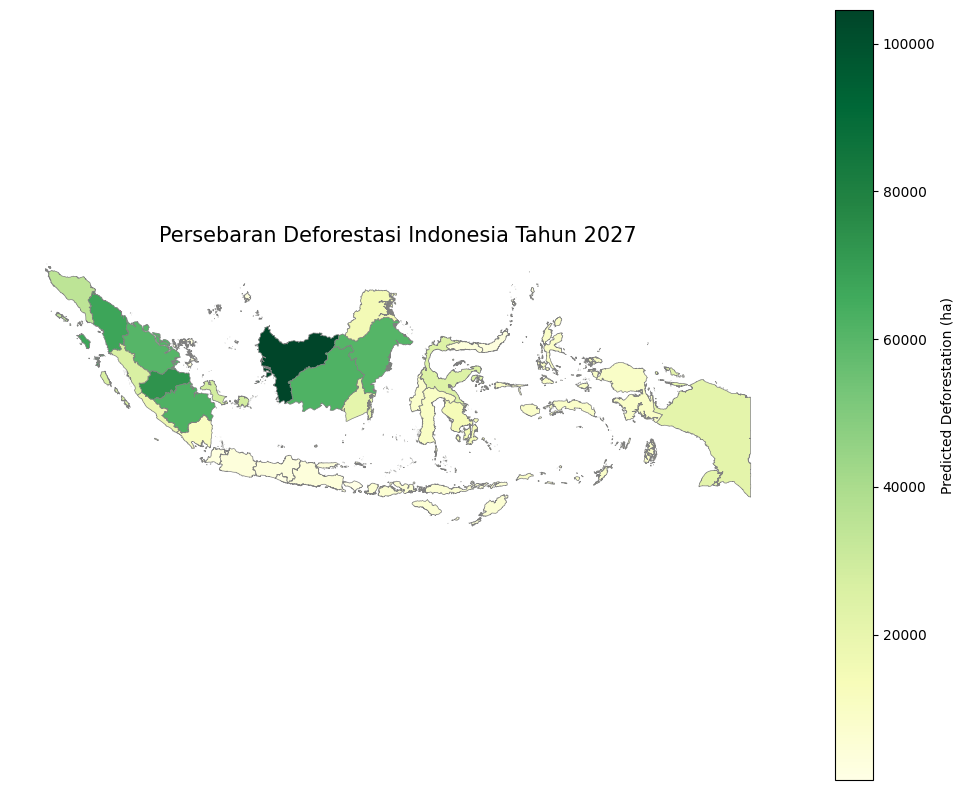

In [142]:
# Peta Persebaran Deforestasi (ha)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_map.plot(
    column="pred_loss_ha",
    cmap="YlGn",
    linewidth=0.5,
    edgecolor="gray",
    legend=True,
    legend_kwds={"label": "Predicted Deforestation (ha)", "orientation": "vertical"},
    ax=ax
)
ax.set_title("Persebaran Deforestasi Indonesia Tahun 2027", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.savefig("/content/peta_deforestasi_2027.png", dpi=200)
plt.show()


“Persebaran Deforestasi Indonesia Tahun 2027” menunjukkan bahwa peta ini menggambarkan perkiraan luas deforestasi (kehilangan hutan) di berbagai provinsi di Indonesia pada tahun 2027.
Peta ini memberikan gambaran visual yang berguna untuk:

1. Mengidentifikasi daerah prioritas konservasi.
2. Menilai dampak kebijakan lingkungan.
3. Merencanakan strategi mitigasi deforestasi di masa depan.

Secara keseluruhan, peta ini adalah hasil analisis spasial prediktif yang memperkirakan luas area hutan yang akan hilang di berbagai provinsi Indonesia pada tahun 2027, dengan tujuan mendukung perencanaan lingkungan dan kebijakan kehutanan yang berkelanjutan.

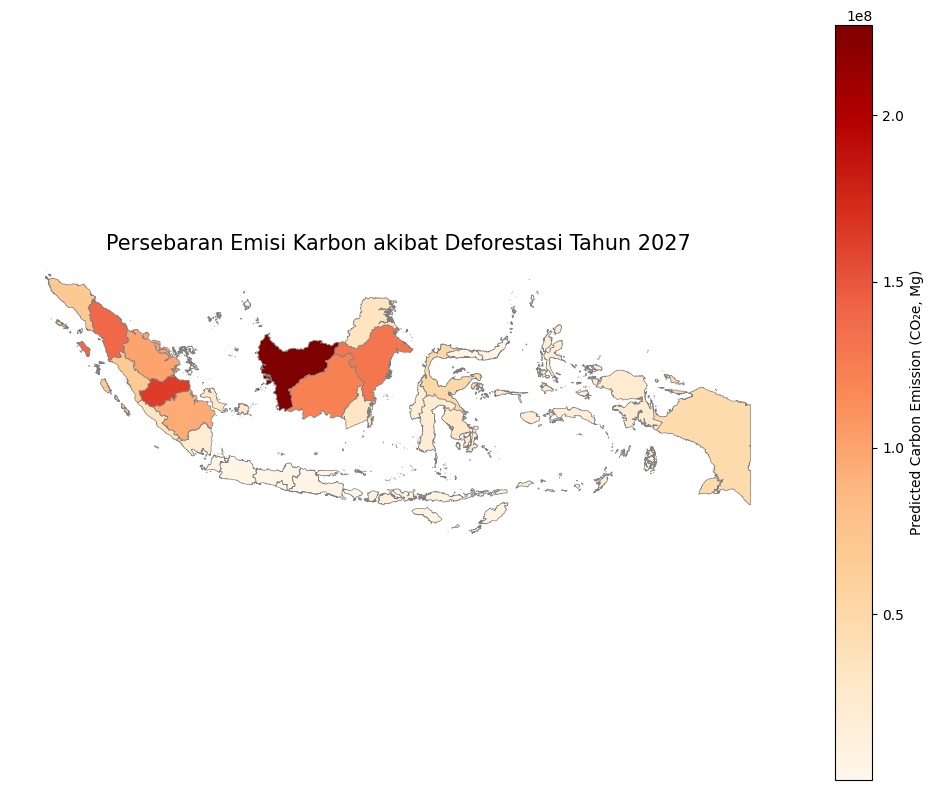

In [95]:
# Peta Persebaran Emisi Karbon (CO₂e)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_map.plot(
    column="emission_estimated_CO2e",
    cmap="OrRd",
    linewidth=0.5,
    edgecolor="gray",
    legend=True,
    legend_kwds={"label": "Predicted Carbon Emission (CO₂e, Mg)", "orientation": "vertical"},
    ax=ax
)
ax.set_title("Persebaran Emisi Karbon akibat Deforestasi Tahun 2027", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.savefig("/content/peta_emisi_karbon_2027.png", dpi=200)
plt.show()

Peta ini digunakan untuk menunjukkan sebaran spasial (per wilayah) emisi karbon yang diperkirakan terjadi akibat deforestasi di tahun 2027.
Dengan visualisasi seperti ini, di dapat informasi dimana saja provinsi yang berpotensi menyumbang emisi terbesar.

Interpretasi Peta.

1. Kalimantan Tengah dan Kalimantan Timur tampak berwarna merah tua, artinya diprediksi akan menjadi penyumbang emisi karbon terbesar pada 2027.
2. Wilayah seperti Jawa dan Nusa Tenggara terlihat lebih terang/pucat, artinya memiliki tingkat deforestasi dan emisi yang lebih rendah.
3. Pola ini menunjukkan bahwa deforestasi (dan emisi karbon) masih terkonsentrasi di wilayah hutan tropis besar seperti Sumatra dan Kalimantan.

# Kesimpulan

Berdasarkan hasil evaluasi model XGBoost, diperoleh nilai R² sebesar 0.904 dan Normalized RMSE sebesar 0.078, menunjukkan bahwa model memiliki kemampuan prediksi yang kuat dan akurat dalam memproyeksikan kehilangan tutupan pohon pada tingkat subnasional di Indonesia. Pola penurunan error selama pelatihan menggambarkan konvergensi yang baik tanpa overfitting berarti. Pendekatan ini sejalan dengan praktik analisis data profesional dan dapat digunakan untuk mendukung pengambilan kebijakan berbasis data terkait SDGs 15, seperti pengelolaan lahan, keanekaragaman hayati, dan konservasi hutan.

In [96]:
# Save the trend_all DataFrame to a CSV file
output_path_dashboard = "/content/national_deforestation_carbon_trend_2001_2027.csv"
trend_all.to_csv(output_path_dashboard, index=False)
print("CSV file for Looker dashboard saved to:", output_path_dashboard)

CSV file for Looker dashboard saved to: /content/national_deforestation_carbon_trend_2001_2027.csv


In [144]:
display(forecast_full.head())

,subnational1,year,pred_loss_ha,emission_estimated_CO2e,latitude,longitude
0,Aceh,2025,"40,871.26","81,598,648.80",4.22,96.91
1,Aceh,2026,"34,754.39","69,386,438.00",4.22,96.91
2,Aceh,2027,"34,894.40","69,665,968.59",4.22,96.91
3,Bali,2025,586.56,"1,056,959.01",-8.37,115.13
4,Bali,2026,669.99,"1,207,298.34",-8.37,115.13


This interactive map shows the tree cover loss (in hectares) for each province in Indonesia from 2001 to 2027. You can use the layer control on the top right to select and view the deforestation data for different years. The color intensity indicates the magnitude of tree cover loss in each province for the selected year.